In [219]:
!pip install rioxarray -q
!pip install dbfread -q 
!pip install geopandas==0.9.0 -q

In [220]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import rioxarray as rx

#### Load CORINE LU/LC data

In [3]:
corine = xr.open_rasterio('./data/u2018_clc2018_v2020_20u1_raster100m/DATA/U2018_CLC2018_V2020_20u1.tif').squeeze()
corine

<xarray.DataArray (y: 46000, x: 65000)>
[2990000000 values with dtype=int8]
Coordinates:
    band     int64 1
  * y        (y) float64 5.5e+06 5.5e+06 5.5e+06 ... 9.002e+05 9.000e+05
  * x        (x) float64 9.000e+05 9.002e+05 9.002e+05 ... 7.4e+06 7.4e+06
Attributes:
    transform:      (100.0, 0.0, 900000.0, 0.0, -100.0, 5500000.0)
    crs:            +init=epsg:3035
    res:            (100.0, 100.0)
    is_tiled:       1
    nodatavals:     (-128.0,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Area
    DataType:       Thematic

#### Load grid as geopandas GeoDataFrame

In [221]:
grid = gpd.read_file('zip://./grid.zip')
grid = grid.set_crs('epsg:4326').to_crs('epsg:3035')

#### Clip dataset to region extent

In [222]:
grid.total_bounds

array([4197710.47633223, 2387664.80049212, 4324977.40524382,
       2555360.58719977])

In [223]:
corine_region = corine.sel(x=np.arange(4197710, 4324977, 100), y=np.arange(2387664, 2555360, 100), method='nearest')

#### Plot LULC

In [224]:
# Obtain LULC class labels from supplmentary .tif.var.dbf file
import dbfread
records = []
for record in dbfread.DBF('./data/u2018_clc2018_v2020_20u1_raster100m/DATA/U2018_CLC2018_V2020_20u1.tif.vat.dbf'):
     records.append(record)

In [136]:
values = pd.DataFrame(records)
values.head()

,Value,Count,LABEL3,Red,Green,Blue,CODE_18
0,1,800699.0,Continuous urban fabric,0.901961,0.000000,0.301961,111
1,2,17085234.0,Discontinuous urban fabric,1.000000,0.000000,0.000000,112
2,3,3210212.0,Industrial or commercial units,0.800000,0.301961,0.949020,121
3,4,414626.0,Road and rail networks and associated land,0.800000,0.000000,0.000000,122
4,5,122685.0,Port areas,0.901961,0.800000,0.800000,123


In [225]:
# Create colormap using colors specified in supplementary files
colors = [(row.Red, row.Green, row.Blue) for index, row in values.iterrows()]
cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', colors, N=len(colors))

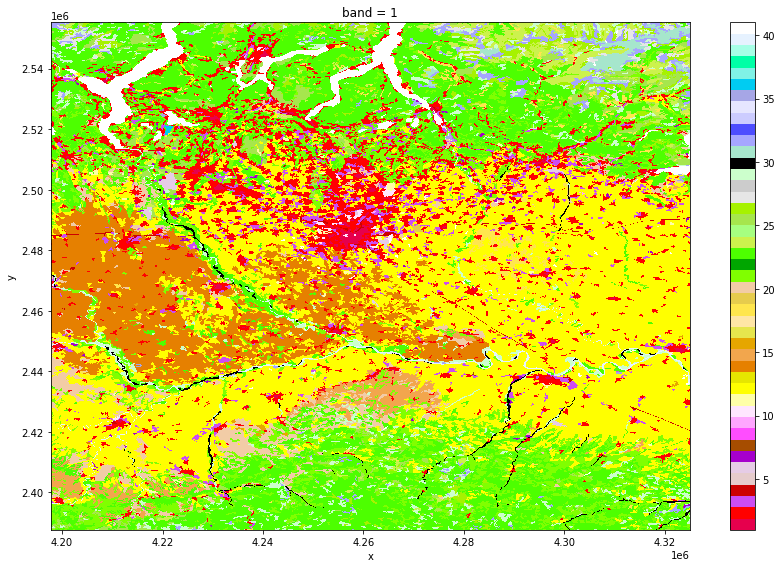

In [218]:
corine_region.plot(cmap=cmap)
fig = plt.gcf()
fig.set_size_inches(11,8)
plt.tight_layout()
plt.savefig('LULC.png', dpi=240)

#### Plot bar chart of LULC class frequencies

In [196]:
df = corine_region.to_dataframe(name='corine').reset_index()
df = df.groupby('corine').count()[['band']]
df.head()

,band
corine,
1,9717
2,187649
3,50492
4,4301
6,3386


In [199]:
bar_x = [values.set_index('Value').loc[x, 'LABEL3'] for x in list(set(df.index.values))]

<ipython-input-215-3a3c51587f4f>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(bar_x, rotation=90)
<ipython-input-215-3a3c51587f4f>:7: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


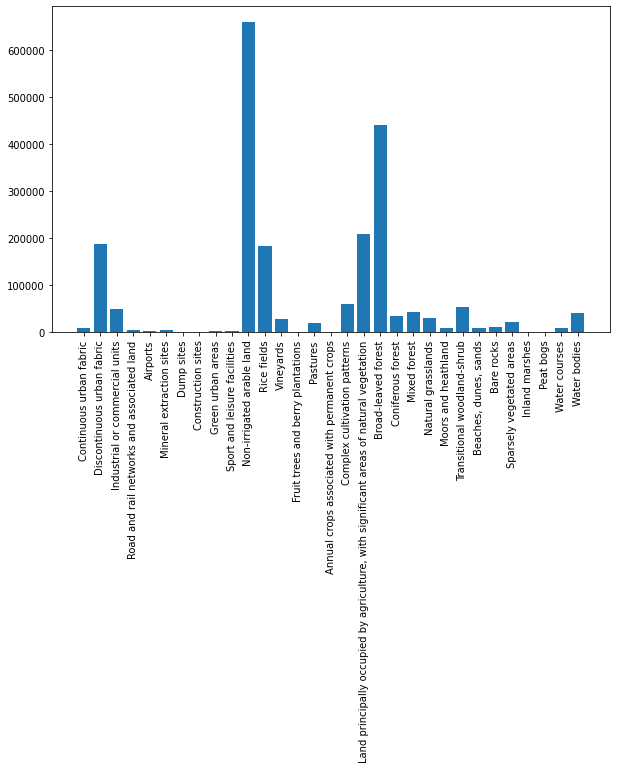

In [215]:
plt.bar(bar_x, df.band)
fig = plt.gcf()
ax = plt.gca()

ax.set_xticklabels(bar_x, rotation=90)
fig.set_size_inches(10,6)
plt.tight_layout()
plt.savefig('LULC_freqs.png', dpi=240)